In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from tqdm import tqdm
from datetime import datetime

from matplotlib import rcParams
rcParams.update({
    "text.usetex": True
})

## dTEC series reading

In [2]:
with open("./data/PTEX_dtec_subseries.dat", "+r") as DTECin:
    file_lines = DTECin.readlines()
    total_series = int(file_lines[0])

    prn_series = []
    time_series = []
    dtec_series = []
    for n in tqdm(range(3, 3*total_series + 1, 3)):
        prn_n_data = int(file_lines[n-2])
        time_n_data = np.array(tuple(map(lambda x: datetime.fromisoformat(x), [time_stamp.strip() for time_stamp in file_lines[n-1].split(",")])))
        dtec_n_data = np.array(tuple(map(lambda x: float(x), file_lines[n].split(","))))

        prn_series.append(prn_n_data)
        time_series.append(time_n_data)
        dtec_series.append(dtec_n_data)
    prn_series = np.array(prn_series)

100%|██████████| 4313/4313 [00:01<00:00, 3564.39it/s]


## Outliers index reading

In [3]:
cluster_dtec_results = np.loadtxt("./data/PTEX_2018_2019_clustering.dat", dtype = int, delimiter = ",")
ArgOutliers = np.argwhere(cluster_dtec_results[:,1] == -1).flatten()
ArgNotOutliers = np.argwhere(cluster_dtec_results[:,1] != -1).flatten()

## Visualization of samples of outliers

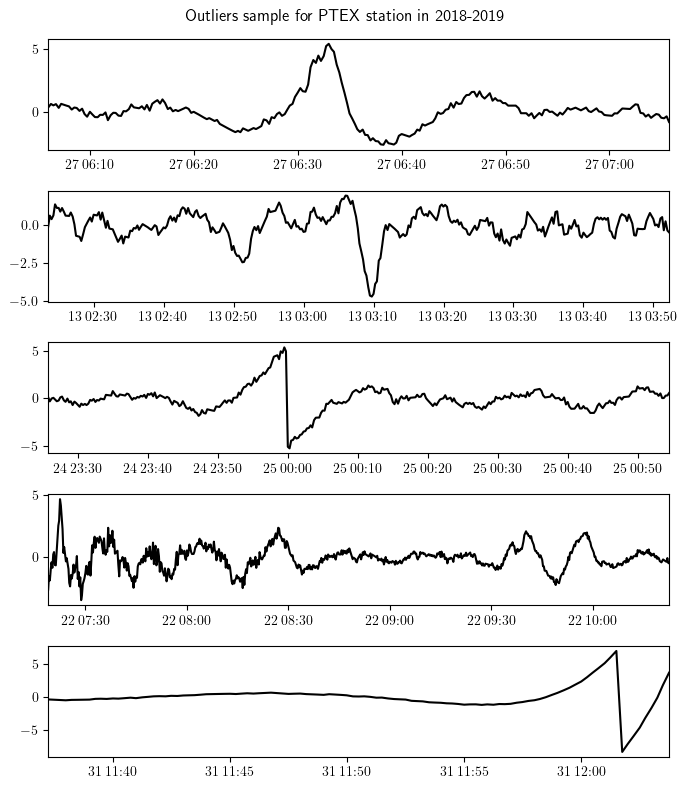

In [4]:
SizeSample = 5
SampleIndexOutlers = np.random.choice(ArgOutliers, size = SizeSample, replace = False)

FigOutliers, SubplotsOut = plt.subplots(nrows = SizeSample, ncols = 1, figsize = (7, 8))
for n, index in enumerate(SampleIndexOutlers):
    SubplotsOut[n].plot(time_series[index], dtec_series[index], "-k", linewidth = 1.5)
    SubplotsOut[n].set_xlim(time_series[index][0], time_series[index][-1])

FigOutliers.suptitle("Outliers sample for PTEX station in 2018-2019")
FigOutliers.tight_layout()

## Visualization of samples per cluster without outliers

In [5]:
def SelectSampleByOrder(order_array:np.ndarray, num_sample:int = 2) -> np.ndarray:
    """
    Obtain sample of 3 * num_sample by selecting elements on the start, middle and end
    values of the order_array.

    Input:
    - order_array: array with ordered numbers
    - num_sample: number of samples to be selected

    Output:
    - sample: array with selected samples from the start, middle and end of the ordered array
    """
    num_order = order_array.size
    if num_order < 3 * num_sample:
        raise ValueError("The number of samples is greater than the number of elements in the array")
    
    # Use slicing for concise assignment
    start_samples = [k for k in range(num_sample)]
    middle_start = num_order // 2 - num_sample // 2
    middle_samples = [middle_start + k for k in range(num_sample)]
    end_samples = [num_order - 1 - k for k in range(num_sample)]
    
    # Concatenate the slices
    sample = (np.concatenate([start_samples, middle_samples, end_samples]) + 1).tolist()
    return sample

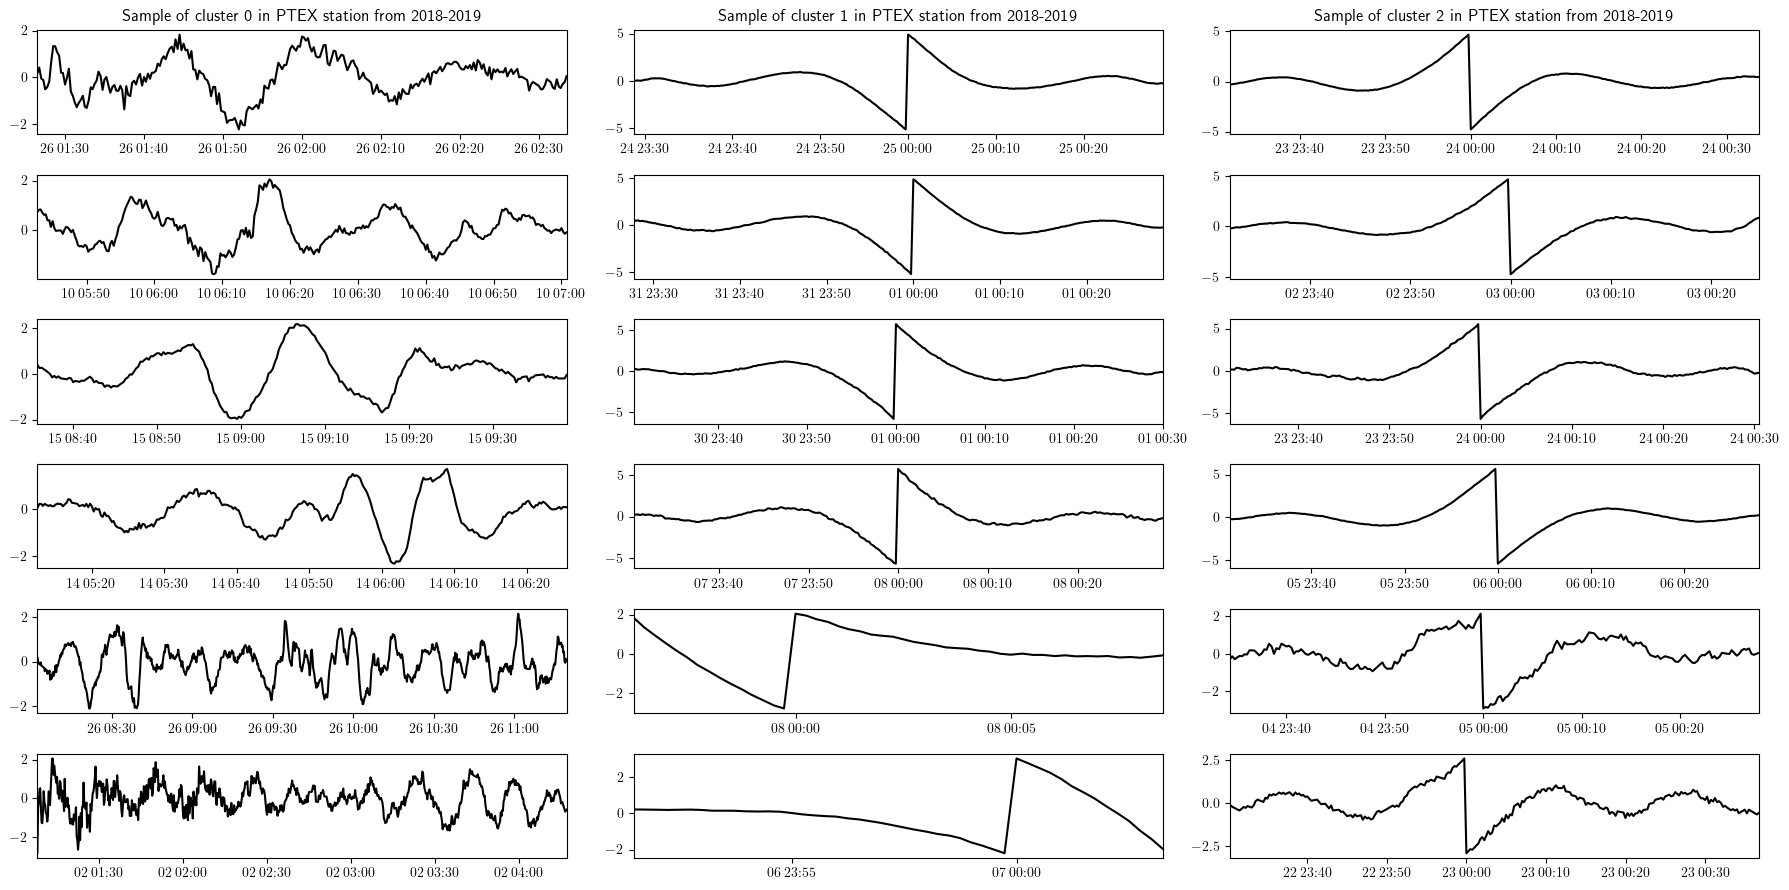

In [6]:
UniqueLabels = np.unique(cluster_dtec_results[ArgNotOutliers, 1]).astype(int)
SizeSample = 2

FigLabel, SubplotsLabel = plt.subplots(ncols = UniqueLabels.size, nrows = 3 * SizeSample, figsize = (18, 9))
for cluster_label in UniqueLabels:
    cluster_labeling = cluster_dtec_results[:, 1] == cluster_label
    order_cluster = cluster_dtec_results[cluster_labeling, ::2]
    order_sample_by_cluster = SelectSampleByOrder(order_cluster[:, 1], SizeSample)
    
    sample_by_cluster = [np.where(order_cluster[:, 1] == index, order_cluster[:, 0], -1) for index in order_sample_by_cluster]
    sample_by_cluster = [index_list[index_list != -1][0] for index_list in sample_by_cluster if index_list[index_list != -1].size > 0]

    for k, index in enumerate(sample_by_cluster):
        SubplotsLabel[k, cluster_label].plot(time_series[index], dtec_series[index], "-k", linewidth = 1.5)
        SubplotsLabel[k, cluster_label].set_xlim(time_series[index][0], time_series[index][-1])
    SubplotsLabel[0, cluster_label].set_title(f"Sample of cluster {cluster_label} in PTEX station from 2018-2019")

FigLabel.tight_layout()

## Number of series per satellite in each cluster

In [7]:
counter_series_per_satelite = {k_cluster:{PRN_number: sum((cluster_dtec_results[:,1] == k_cluster) & (prn_series == PRN_number))/sum(cluster_dtec_results[:,1] == k_cluster) for PRN_number in np.unique(prn_series)} for k_cluster in np.unique(cluster_dtec_results[:,1])}

dtec_time_diff = np.array([np.ptp(time_series[n]).total_seconds() for n in range(total_series)])
norm_sum_time_diff_per_satelite = {k_cluster:{PRN_number: sum(dtec_time_diff[(cluster_dtec_results[:,1] == k_cluster) & (prn_series == PRN_number)])/sum(dtec_time_diff[cluster_dtec_results[:,1] == k_cluster]) for PRN_number in np.unique(prn_series)} for k_cluster in np.unique(cluster_dtec_results[:,1])}

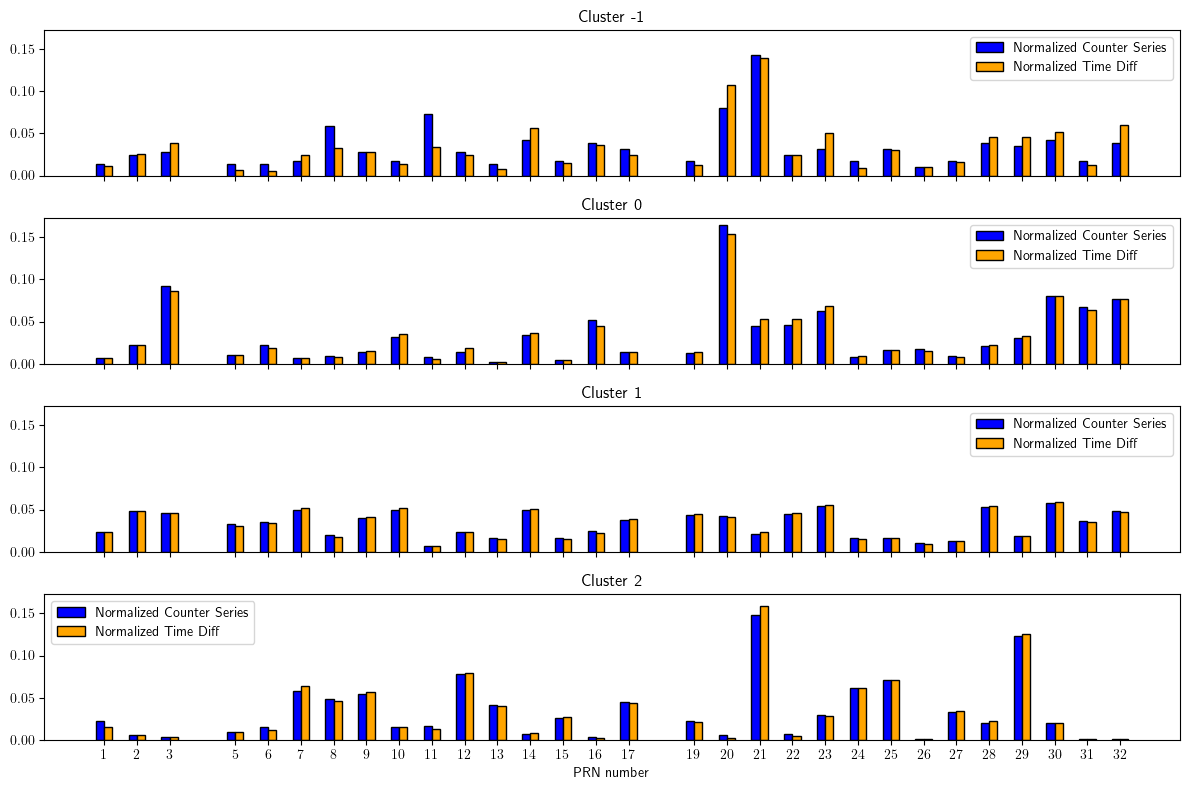

In [8]:
FigureSat, subplots_satellites = plt.subplots(nrows=len(counter_series_per_satelite.keys()), figsize=(12, 8), sharex=True, sharey=True)

bar_width = 0.25  # Width of each bar
for k, k_cluster in enumerate(counter_series_per_satelite.keys()):
    prn_numbers = np.array(list(counter_series_per_satelite[k_cluster].keys()))
    bar1_values = np.array(list(counter_series_per_satelite[k_cluster].values()))
    bar2_values = np.array(list(norm_sum_time_diff_per_satelite[k_cluster].values()))
    
    # Plot the first set of bars
    subplots_satellites[k].bar(prn_numbers - bar_width / 2, bar1_values, width=bar_width, color="blue", edgecolor="black", label="Normalized Counter Series")
    
    # Plot the second set of bars
    subplots_satellites[k].bar(prn_numbers + bar_width / 2, bar2_values, width=bar_width, color="orange", edgecolor="black", label="Normalized Time Diff")
    
    subplots_satellites[k].set_title(f"Cluster {k_cluster}")
    subplots_satellites[k].legend()

subplots_satellites[-1].set_xlabel("PRN number")
subplots_satellites[0].set_xticks(np.unique(prn_series))
FigureSat.tight_layout()

## Visualization of clusters on local time and day of year

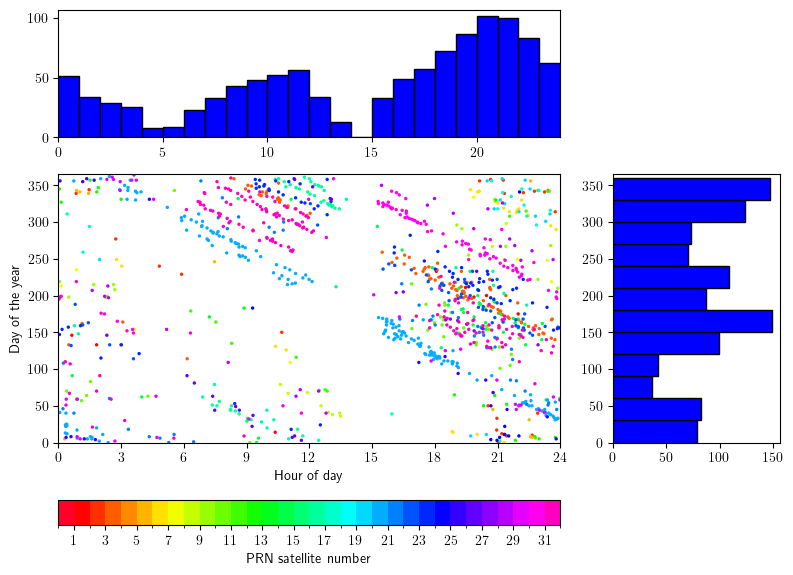

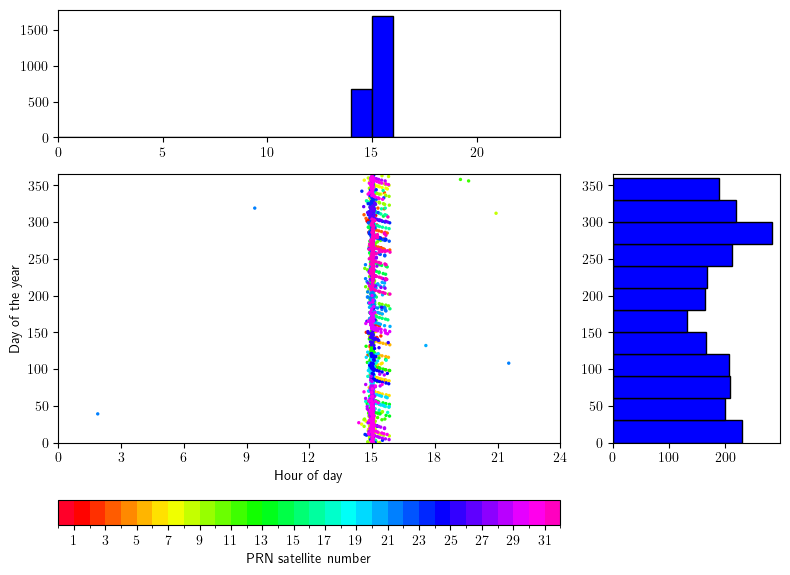

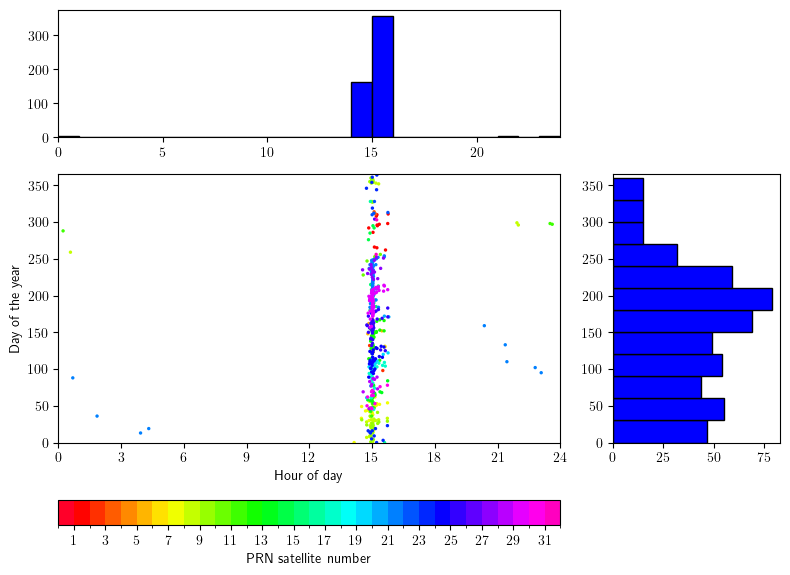

In [ ]:
cmap = plt.get_cmap("gist_rainbow", 32)
norm = mcolors.BoundaryNorm(boundaries = np.arange(0, 33), ncolors = 32)

for label in UniqueLabels:
    SampleIndexByLabel = np.argwhere(cluster_dtec_results[:,1] == label).flatten()
    HourPositions, DayMonthPositions = [], []
    for index in SampleIndexByLabel:
        current_prom_series = time_series[index]

        HourPosition = current_prom_series[0] + 0.5*(current_prom_series[0] - current_prom_series[-1])
        HourPosition = HourPosition.hour + HourPosition.minute/60.0 + HourPosition.second/3600.0

        DayMonthPosition = current_prom_series.astype('datetime64[D]')[current_prom_series.size//2]

        HourPositions.append(HourPosition)
        DayMonthPositions.append(DayMonthPosition)

    HourPositions = np.array(HourPositions, dtype = float)
    HourPositions = HourPositions - 8.0
    HourPositions = np.where(HourPositions < 0, HourPositions + 24.0, HourPositions)

    DayMonthPositions = np.array(DayMonthPositions, dtype = "datetime64[D]")
    TransDays = (DayMonthPositions - DayMonthPositions.min()).astype("timedelta64[D]").astype(int)
    TransDays = TransDays % 365

    Figure, Subplot = plt.subplot_mosaic([["HourHist", "."],
                                          ["Scatter", "DayMonthHist"]],
                                          height_ratios = (1,3),
                                          width_ratios = (3,1),
                                          figsize = (8, 6))

    Subplot["HourHist"].hist(HourPositions, facecolor = "blue", edgecolor = "black", bins = tuple(range(0, 25)))[1]
    Subplot["DayMonthHist"].hist(TransDays, facecolor = "blue", edgecolor = "black", bins = tuple(range(0, 365, 30)), orientation = "horizontal")[1]


    ScatterTime = Subplot["Scatter"].scatter(HourPositions, TransDays, ec = "None", s = 6, c = prn_series[SampleIndexByLabel], cmap = cmap, norm = norm)
    cbar = Figure.colorbar(ScatterTime, ax = Subplot["Scatter"], ticks = np.arange(1, 33, 2), orientation = "horizontal")
    cbar.set_label("PRN satellite number")  # Label for the colorbar
    cbar.set_ticks(np.arange(1, 33, 2))

    Subplot["Scatter"].set_xlim(0, 24)
    Subplot["Scatter"].set_xticks(np.arange(0, 25, 3))
    Subplot["Scatter"].set_ylim(0, 365)
    Subplot["HourHist"].set_xlim(0, 24)
    Subplot["DayMonthHist"].set_ylim(0, 365)

    Subplot["Scatter"].set_xlabel("Hour of day")
    Subplot["Scatter"].set_ylabel("Day of the year")

    Figure.tight_layout()

    scatter_pos = Subplot["Scatter"].get_position()
    right_pos = Subplot["DayMonthHist"].get_position()

    # Set the right subplot's height to match the scatter plot's height
    Subplot["DayMonthHist"].set_position([
        right_pos.x0,          # Keep x-position
        scatter_pos.y0,        # Align bottom
        right_pos.width,       # Keep width
        scatter_pos.height     # Match height
    ])+